
### Demonstration and testing only, please use "All_Metrics_Generator.ipynb"
### to generate all fingerprints models, which will save all resaults into a single file
---



# Import Modules

In [ ]:
#Only run at the first time while using Google colab
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 7.6MB/s 


In [ ]:
print("Importing modules...")
import numpy as np
import pandas as pd
import scipy
import sklearn
import skmultilearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss,classification_report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.problem_transform import ClassifierChain
print("...Complete")

Importing modules...
...Complete


# Load Data

In [ ]:
#Enable google drive for Google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#navigate to shared folder
cd '/content/drive/My Drive/2019- Zehao'

/content/drive/My Drive/2019- Zehao


In [ ]:
FINGERPRINT = "Top5" #Top5, Top10, Top15, Top20, Top25, Top50, FCFP0, FCFP2, FCFP4
PATH = "{0}_Fingerprint".format(FINGERPRINT) 
# PATH = "CDK-{0}".format(FINGERPRINT) #  For FCFP file
print("Loading datasets...")
df = pd.read_csv("{0}/{1}.csv.gz".format(PATH,FINGERPRINT), compression='gzip')  
# df = pd.read_csv("{0}/{1}.csv".format(PATH,FINGERPRINT))  # For FCFP file

df = df.reindex(sorted(df.columns), axis=1) # sort columns by name

Loading datasets...


In [ ]:
# Visualise split results
def drawCompare():
    sns.set(rc={'figure.figsize':(24,5)})
    class_counts_train = []
    class_counts_test = []
    for l in y.columns:
        class_counts_train.append(y_train[l].sum())
        class_counts_test.append(y_test[l].sum())
    class_distr = pd.DataFrame({'ClassNo':list(range(1,38)),'Class':y.columns,'TrainCounts':class_counts_train,'TestCounts':class_counts_test})    
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(ncols=2)
    sns.set(rc={'figure.figsize':(24,5)})
    sns.barplot(x="ClassNo", y="TrainCounts", data=class_distr, ax=axs[0],color='#1e446b')
    sns.barplot(x="ClassNo", y="TestCounts", data=class_distr, ax=axs[1],color='#1e446b')
    return class_distr

# Data Split

## Random Split

only demonstration data set distribution, no training in further steps

In [ ]:
y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] #remove columns containing 'bit' and RowID
X = df.filter(like='bit', axis=1)  #select rows containing 'bit' 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
ClassNo,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
Class,C-C Bond Formation (Acylation),C-C Bond Formation (Condensation),C-C Bond Formation (Coupling),C-C Bond Formation (Methylation),C-C Bond Formation (Olefination),C-N Bond Formation (Amination),C-N Bond Formation (Condensation),C-N Bond Formation (N-acetylation),C-N Bond Formation (N-alkylation),C-N Bond Formation (N-arylation),C-N Bond Formation (N-methylation),C-N Bond Formation (Urea formation),C-O Bond Formation (Esterification),C-O Bond Formation (Etherification),Cleavage (Hydrolysis),Deprotection (N-Benzyl),Deprotection (N-t-Butyloxycarbonyl),Functional Conversion (Alcohol to alkene),Functional Conversion (Cyano to carbamoyl),Functional Conversion (Hydroxy to methoxy),Functional Conversion (Oxidation),Functional Conversion (Pyridone to chloropyrid...,Functional Conversion (Reduction),Functional Conversion (Sulfanyl to sulfinyl),Functional Elimination (Debromination),Functional Elimination (Decarboxylation),Functional Elimination (Deoxygenation),Functional Introduction (Bromination),Functional Introduction (Hydroxylation),Functional Introduction (Iodination),Functional Introduction (Nitration),Other Bond Formation (Sulfonamide formation),Protection (O-Acetyl),Synthesis (1-2-4-Oxadiazole),Synthesis (Pyrazole),Synthesis (Thiazole),Synthesis (Thioether)
TrainCounts,23,28,67,75,26,79,118,61,37,90,92,71,65,77,29,44,62,39,30,48,34,13,30,48,32,40,42,81,31,56,45,60,39,45,23,24,68
TestCounts,4,5,16,21,6,20,25,13,5,19,22,19,14,20,8,10,20,8,7,11,8,1,8,8,4,10,11,17,7,9,7,17,10,9,3,5,14


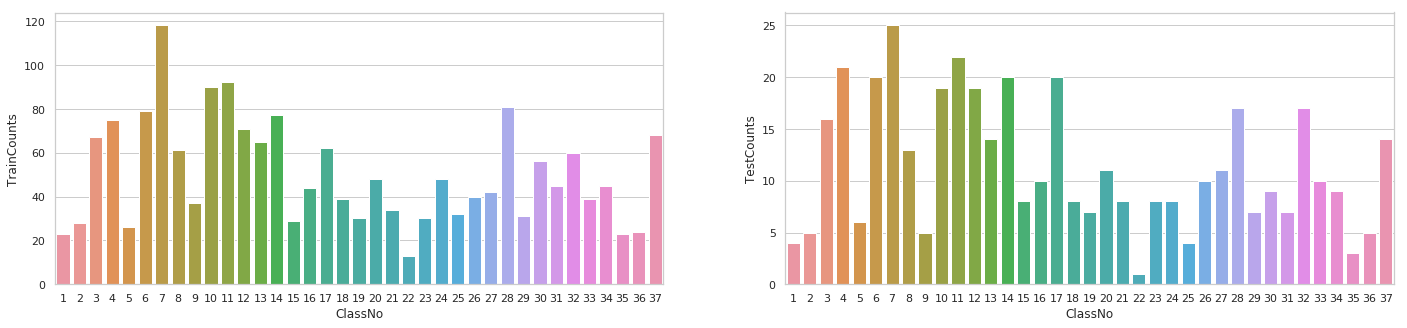

In [ ]:
class_distr = drawCompare()
class_distr.T

In [ ]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
classPair = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_train), order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_test), order=2) for combination in row),
    'full': Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y), order=2) for combination in row),
}).fillna(0.0)
classPair.T

,"(0, 0)","(0, 1)","(0, 10)","(0, 11)","(0, 12)","(0, 13)","(0, 14)","(0, 15)","(0, 16)","(0, 17)","(0, 18)","(0, 19)","(0, 2)","(0, 20)","(0, 21)","(0, 22)","(0, 23)","(0, 24)","(0, 25)","(0, 26)","(0, 27)","(0, 28)","(0, 29)","(0, 3)","(0, 30)","(0, 31)","(0, 32)","(0, 33)","(0, 34)","(0, 35)","(0, 36)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(1, 1)","(1, 10)","(1, 11)",...,"(8, 27)","(8, 28)","(8, 29)","(8, 30)","(8, 31)","(8, 32)","(8, 33)","(8, 34)","(8, 35)","(8, 36)","(8, 8)","(8, 9)","(9, 10)","(9, 11)","(9, 12)","(9, 13)","(9, 14)","(9, 15)","(9, 16)","(9, 17)","(9, 18)","(9, 19)","(9, 20)","(9, 21)","(9, 22)","(9, 23)","(9, 24)","(9, 25)","(9, 26)","(9, 27)","(9, 28)","(9, 29)","(9, 30)","(9, 31)","(9, 32)","(9, 33)","(9, 34)","(9, 35)","(9, 36)","(9, 9)"
train,23.0,15.0,20.0,17.0,15.0,20.0,12.0,12.0,14.0,10.0,13.0,18.0,21.0,16.0,7.0,12.0,14.0,10.0,13.0,15.0,23.0,14.0,22.0,22.0,22.0,18.0,16.0,12.0,15.0,11.0,19.0,15.0,19.0,19.0,15.0,16.0,21.0,28.0,26.0,20.0,...,32.0,17.0,23.0,21.0,30.0,22.0,20.0,17.0,18.0,27.0,37.0,32.0,63.0,58.0,41.0,49.0,20.0,31.0,42.0,28.0,24.0,36.0,28.0,12.0,26.0,34.0,28.0,28.0,34.0,53.0,21.0,42.0,36.0,51.0,32.0,31.0,19.0,21.0,51.0,90.0
test,4.0,2.0,4.0,3.0,2.0,4.0,2.0,2.0,2.0,1.0,2.0,3.0,3.0,3.0,0.0,2.0,2.0,2.0,1.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,3.0,1.0,3.0,2.0,3.0,2.0,4.0,4.0,3.0,2.0,4.0,5.0,5.0,4.0,...,5.0,3.0,2.0,3.0,4.0,2.0,2.0,2.0,4.0,2.0,5.0,5.0,14.0,13.0,9.0,13.0,6.0,6.0,7.0,5.0,6.0,8.0,6.0,1.0,7.0,3.0,4.0,6.0,9.0,13.0,6.0,7.0,6.0,13.0,7.0,6.0,3.0,5.0,8.0,19.0
full,27.0,17.0,24.0,20.0,17.0,24.0,14.0,14.0,16.0,11.0,15.0,21.0,24.0,19.0,7.0,14.0,16.0,12.0,14.0,19.0,27.0,17.0,25.0,26.0,25.0,21.0,19.0,13.0,18.0,13.0,22.0,17.0,23.0,23.0,18.0,18.0,25.0,33.0,31.0,24.0,...,37.0,20.0,25.0,24.0,34.0,24.0,22.0,19.0,22.0,29.0,42.0,37.0,77.0,71.0,50.0,62.0,26.0,37.0,49.0,33.0,30.0,44.0,34.0,13.0,33.0,37.0,32.0,34.0,43.0,66.0,27.0,49.0,42.0,64.0,39.0,37.0,22.0,26.0,59.0,109.0


In [ ]:
#random train/test set distribution difference (Based on binary relevence)
print(np.absolute(classPair['train'] - classPair['test']).mean()) #for each class, count difference, and calculate mean
# use split(80/20) sample to simulate full set distribution, and calculate difference, identical sets should have 0 value
print(np.absolute(classPair['train']/0.8 - classPair['test']/0.2).mean())
from scipy import stats
stats.ks_2samp(class_distr['TrainCounts']/0.8,class_distr['TestCounts']/0.2)

21.95163584637269
9.415007112375534


Ks_2sampResult(statistic=0.16216216216216217, pvalue=0.7227565530633371)

## Stratified Split

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split
np.random.seed(0) 
X = df.filter(like='bit', axis=1)
y = df[df.columns.drop(list(df.filter(regex='bit|StringFP|row ID')))] #remove columns containing 'bit' and RowID

#stratified sampling http://scikit.ml/stratification.html
X_train, y_train, X_test, y_test = iterative_train_test_split(X.values, y.values, test_size = 0.2)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
y_test.columns, y_train.columns = y.columns,y.columns
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_test.columns, X_train.columns = X.columns,X.columns
#y_train, y_test = y_train.set_index(X_train['row ID']), y_test.set_index(X_test['row ID'])
#X_train, X_test = X_train.set_index('row ID'), X_test.set_index('row ID')

print("...Complete")
print(df.shape)
print(X.shape, y.shape)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print('1_in_X:',(X.values==1).sum(),'0_in_X:',(X.values==0).sum(), 'Density_X:',(X.values==1).sum()/(X.shape[0] * X.shape[1]))
print('1_in_y:',(y.values==1).sum(),'0_in_y:',(y.values==0).sum(), 'Density_y:',(y.values==1).sum()/(y.shape[0] * y.shape[1]))


...Complete
(20142, 127)
(20142, 89) (20142, 37)
(16249, 89) (16249, 37) (3893, 89) (3893, 37)
1_in_X: 342384 0_in_X: 1450254 Density_X: 0.1909945008417762
1_in_y: 27481 0_in_y: 717773 Density_y: 0.036874676284863954


In [ ]:
FPD = X.sum().sort_values(ascending=False)
print('Total Used Fingerprint Bits:',len(FPD[FPD != 0]))
print('Min Used Fingerprint Bits Per Entry:',X.T.sum().min())
print('Mean Used Fingerprint Bits Per Entry:',X.T.sum().mean())
print('Median Used Fingerprint Bits Per Entry:',X.T.sum().median())
print('Max Used Fingerprint Bits Per Entry:',X.T.sum().max())

Total Used Fingerprint Bits: 21
Min Used Fingerprint Bits Per Entry: 0
Mean Used Fingerprint Bits Per Entry: 6.138317757009346
Median Used Fingerprint Bits Per Entry: 6.0
Max Used Fingerprint Bits Per Entry: 13


In [ ]:
print('Min Reaction Classes Per Entry:',y.T.sum().min())
print('Mean Reaction Classes Per Entry:',y.T.sum().mean())
print('Median Reaction Classes Per Entry:',y.T.sum().median())
print('Max Reaction Classes Per Entry:',y.T.sum().max())

Min Reaction Classes Per Entry: 1
Mean Reaction Classes Per Entry: 4.719626168224299
Median Reaction Classes Per Entry: 2.0
Max Reaction Classes Per Entry: 35


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
ClassNo,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
Class,C-C Bond Formation (Acylation),C-C Bond Formation (Condensation),C-C Bond Formation (Coupling),C-C Bond Formation (Methylation),C-C Bond Formation (Olefination),C-N Bond Formation (Amination),C-N Bond Formation (Condensation),C-N Bond Formation (N-acetylation),C-N Bond Formation (N-alkylation),C-N Bond Formation (N-arylation),C-N Bond Formation (N-methylation),C-N Bond Formation (Urea formation),C-O Bond Formation (Esterification),C-O Bond Formation (Etherification),Cleavage (Hydrolysis),Deprotection (N-Benzyl),Deprotection (N-t-Butyloxycarbonyl),Functional Conversion (Alcohol to alkene),Functional Conversion (Cyano to carbamoyl),Functional Conversion (Hydroxy to methoxy),Functional Conversion (Oxidation),Functional Conversion (Pyridone to chloropyrid...,Functional Conversion (Reduction),Functional Conversion (Sulfanyl to sulfinyl),Functional Elimination (Debromination),Functional Elimination (Decarboxylation),Functional Elimination (Deoxygenation),Functional Introduction (Bromination),Functional Introduction (Hydroxylation),Functional Introduction (Iodination),Functional Introduction (Nitration),Other Bond Formation (Sulfonamide formation),Protection (O-Acetyl),Synthesis (1-2-4-Oxadiazole),Synthesis (Pyrazole),Synthesis (Thiazole),Synthesis (Thioether)
TrainCounts,168,304,2044,1049,262,847,1883,374,341,1250,1487,637,598,1337,186,250,706,537,218,443,351,175,309,514,250,402,380,1228,175,466,347,677,236,302,139,390,722
TestCounts,42,76,511,262,65,212,471,94,85,312,372,159,150,334,47,62,177,134,54,111,88,44,77,129,62,101,95,307,44,117,87,169,59,75,35,98,180


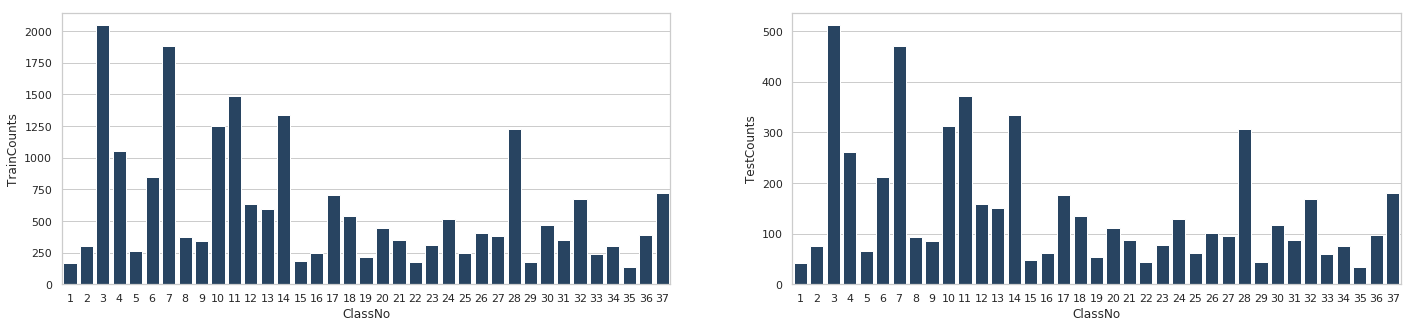

In [ ]:
#Compare training set and test set
class_distr = drawCompare()
class_distr.T

In [ ]:
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
classPair = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_train), order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y_test), order=2) for combination in row),
    'full': Counter(str(combination) for row in get_combination_wise_output_matrix(np.array(y), order=2) for combination in row),

}).fillna(0.0)
classPair.T
# see more from: http://scikit.ml/stratification.html

,"(0, 0)","(0, 1)","(0, 10)","(0, 11)","(0, 12)","(0, 13)","(0, 14)","(0, 15)","(0, 17)","(0, 18)","(0, 19)","(0, 2)","(0, 20)","(0, 21)","(0, 22)","(0, 23)","(0, 24)","(0, 25)","(0, 26)","(0, 27)","(0, 28)","(0, 29)","(0, 3)","(0, 30)","(0, 31)","(0, 32)","(0, 33)","(0, 34)","(0, 35)","(0, 36)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(1, 1)","(1, 10)","(1, 11)","(1, 12)",...,"(8, 27)","(8, 28)","(8, 29)","(8, 30)","(8, 31)","(8, 32)","(8, 33)","(8, 34)","(8, 35)","(8, 36)","(8, 8)","(8, 9)","(9, 10)","(9, 11)","(9, 12)","(9, 13)","(9, 14)","(9, 15)","(9, 16)","(9, 17)","(9, 18)","(9, 19)","(9, 20)","(9, 21)","(9, 22)","(9, 23)","(9, 24)","(9, 25)","(9, 26)","(9, 27)","(9, 28)","(9, 29)","(9, 30)","(9, 31)","(9, 32)","(9, 33)","(9, 34)","(9, 35)","(9, 36)","(9, 9)"
train,143.0,13.0,35.0,27.0,11.0,27.0,8.0,5.0,8.0,2.0,15.0,46.0,10.0,3.0,10.0,7.0,7.0,8.0,15.0,71.0,3.0,38.0,41.0,36.0,26.0,9.0,11.0,5.0,0.0,31.0,5.0,21.0,36.0,15.0,7.0,44.0,261.0,42.0,23.0,24.0,...,31.0,1.0,17.0,10.0,28.0,9.0,6.0,1.0,10.0,15.0,302.0,34.0,214.0,136.0,54.0,117.0,19.0,57.0,46.0,43.0,13.0,62.0,53.0,20.0,43.0,11.0,18.0,27.0,50.0,201.0,6.0,117.0,74.0,147.0,30.0,55.0,14.0,66.0,125.0,930.0
test,36.0,4.0,18.0,14.0,6.0,11.0,1.0,1.0,0.0,0.0,3.0,19.0,3.0,4.0,2.0,0.0,5.0,1.0,1.0,22.0,0.0,16.0,17.0,15.0,11.0,2.0,3.0,4.0,2.0,14.0,3.0,13.0,12.0,7.0,3.0,18.0,65.0,11.0,5.0,6.0,...,9.0,0.0,5.0,5.0,9.0,2.0,1.0,0.0,3.0,4.0,76.0,9.0,54.0,38.0,13.0,29.0,1.0,14.0,7.0,7.0,4.0,12.0,13.0,8.0,11.0,4.0,9.0,5.0,8.0,55.0,2.0,36.0,32.0,37.0,5.0,10.0,11.0,14.0,41.0,233.0
full,179.0,17.0,53.0,41.0,17.0,38.0,9.0,6.0,8.0,2.0,18.0,65.0,13.0,7.0,12.0,7.0,12.0,9.0,16.0,93.0,3.0,54.0,58.0,51.0,37.0,11.0,14.0,9.0,2.0,45.0,8.0,34.0,48.0,22.0,10.0,62.0,326.0,53.0,28.0,30.0,...,40.0,1.0,22.0,15.0,37.0,11.0,7.0,1.0,13.0,19.0,378.0,43.0,268.0,174.0,67.0,146.0,20.0,71.0,53.0,50.0,17.0,74.0,66.0,28.0,54.0,15.0,27.0,32.0,58.0,256.0,8.0,153.0,106.0,184.0,35.0,65.0,25.0,80.0,166.0,1163.0


In [ ]:
#stratified split, train/test set distribution difference
print(np.absolute(classPair['train'] - classPair['test']).mean())
print(np.absolute(classPair['train']/0.8 - classPair['test']/0.2).mean())
from scipy import stats
stats.ks_2samp(class_distr['TrainCounts']/0.8,class_distr['TestCounts']/0.2)

47.27312138728324
11.01878612716763


Ks_2sampResult(statistic=0.08108108108108109, pvalue=0.9998280831475461)

In [ ]:
class_distr['full'] = class_distr['TrainCounts'] + class_distr['TestCounts']
class_distr['train_diff'] = np.absolute((class_distr['TrainCounts']/(y_train.shape[0]-class_distr['TrainCounts']) - class_distr['full']/(y.shape[0]-class_distr['full'])))
class_distr['test_diff'] = np.absolute((class_distr['TestCounts']/(y_test.shape[0]-class_distr['TestCounts']) - class_distr['full']/(y.shape[0]-class_distr['full'])))
class_distr['Labels Distribution'] = class_distr[['train_diff','test_diff']].mean(axis=1)
class_distr=class_distr.drop(['train_diff','test_diff'], axis=1)
LD = class_distr['Labels Distribution'].mean()
print("Labels Distribution:", LD)
ED = np.mean([abs(y_train.shape[0]-(y.shape[0]*0.8)), abs(y_test.shape[0]-(y.shape[0]*0.2))])
print("Examples Distribution:", ED)
#reference for LD & ED: https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10

Labels Distribution: 0.032362657022738384
Examples Distribution: 9.200000000000006


In [ ]:
def unpivot_y(y, df=False):
  y_flat = y.unstack().reset_index(name='value')
  y_flat.rename(columns={'level_0': 'class'}, inplace=True)
  return y_flat.groupby('class')[['value']].sum() if df==True else y_flat.groupby('class')['value'].sum()

# Training

In [ ]:
def set_problem_transformation(clf, method):
    """
    ====================================================================================
                                  Set Problem Transformation
    ====================================================================================
    Key arguments:
        clf     =  scikit-learn classifier (e.g. RandomForestClassifier())
        method  =  scikit-multilearn problem transformation method among the ones below:
        
                   'BR' = BinaryRelevance()
                   'LP' = LabelPowerset()
                   'CC' = ClassifierChain()
    ====================================================================================
    """
    # define methods
    methods = {'BR' : BinaryRelevance(classifier=clf, require_dense=[True,True]),
               'LP' : LabelPowerset(classifier=clf, require_dense=[True,True]),
               'CC' : ClassifierChain(classifier=clf, require_dense=[True,True])}
    
    # set the problem transformation
    if method in methods.keys():
        pt_clf = methods[method]
        return pt_clf
    else:
        return str(method)+" is not contained among the possible methods (Try to use 'BR', 'LP', or 'CC')"
def metrics_problem_transformation(pt_clf, X_train, y_train, X_test, y_test):
    """
    ====================================================================================
                                  Test Problem Transformation
    ====================================================================================
    Key arguments:
        pt_clf   =  scikit-multilearn problem transformation classifier
        X_train  =  pandas dataframe containing the training set values
        y_train  =  pandas dataframe containing the training set labels
        X_test   =  pandas dataframe containing the test set values
        y_test   =  pandas dataframe containing the test set labels
    ====================================================================================
    """    
    # load modules
    import pandas as pd
    from sklearn.metrics import (accuracy_score, precision_score, f1_score, recall_score, hamming_loss, zero_one_loss)
    
    # train
    print("Fitting the function...")
    pt_clf.fit(X_train, y_train)
    print("...Complete")
    
    # predict and convert
    print("Predicting the entries...")
    y_pred = pt_clf.predict(X_test)
    print("...Complete\n")
    y_pred = y_pred.todense(order=None, out=None)
    y_pred = pd.DataFrame(y_pred, index=y_test.index.values, columns=y_test.columns.values)

    return y_pred


In [ ]:
def get_metrics(y_test, y_pred):  
  # metrics
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    hloss = sklearn.metrics.hamming_loss(y_test, y_pred)
    zero_one_loss = sklearn.metrics.zero_one_loss(y_test, y_pred)
    micro_precision = sklearn.metrics.precision_score(y_test, y_pred, average='micro')
    weighted_precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
    micro_recall = sklearn.metrics.recall_score(y_test, y_pred, average='micro')
    weighted_recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
    macro_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='macro')
    micro_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='micro')
    weighted_f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
    report =  sklearn.metrics.classification_report(y_test, y_pred,output_dict=True)
    
    # list metrics and round them
    metrics = [accuracy, hloss, zero_one_loss, micro_recall, weighted_recall,
              micro_precision, weighted_precision, macro_f1, micro_f1, weighted_f1]
    rnd_metrics =  [round(x,2) for x in metrics]
    
    details={}
    #find lables that has 0 TP prediction 
    repo = round(pd.DataFrame(report),2).T['f1-score']
    details['noTPLabel'] = len(repo[repo==0])
    noTPLabels = [int(x) for x in list(repo[repo==0].index)]
    #confusion[confusion==0].count().where(lambda x : x==0).dropna() #same results

    #count predicted labels number per entry
    rows_pred = y_pred[y_pred==1].T.count() 
    details['minLabelRow'] = rows_pred.min()
    details['medLabelRow'] = rows_pred.median()
    details['meanLabelRow'] = rows_pred.mean()
    details['maxLabelRow'] = rows_pred.max()
    details['noLabelRow'] = rows_pred[rows_pred==0].count()
    
    #count value in confusion matrix
    y_pred[y_pred==0]=-1
    confusion = y_test-y_pred
    details['TP'] = confusion[confusion==0].count().sum()
    details['FN'] = confusion[confusion==2].count().sum()
    details['FP'] = confusion[confusion==-1].count().sum()
    details['TN'] = confusion[confusion==1].count().sum()

    #print (pt_clf)
    print(str(pt_clf).split('(')[0:2])
    print (rnd_metrics)
#     print (round(pd.DataFrame(report),2).T)
    return metrics, details, noTPLabels

In [ ]:
print("Defining the classifiers...")
# define rf classifier
rf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                            min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                            max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, 
                            min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=4, 
                            random_state=11, verbose=0, warm_start=False, class_weight=None)

# define svm classifier
svm = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                C=1.0, multi_class='ovr', fit_intercept=True, intercept_scaling=1, 
                class_weight=None, verbose=0, random_state=11, max_iter=1000)
print("...Complete")

Defining the classifiers...
...Complete


In [ ]:
#DEPRECATION
# Demonstration only, please use "All_Metrics_Generator.ipynb"
# to generate all fingerprints model, which save reasults in a single file
from warnings import filterwarnings
filterwarnings('ignore')
FILE_NAME = '{0}-metrics.CSV'.format(FINGERPRINT)
methods_to_test = ['BR','LP','CC']
classifiers_to_test = [rf, svm]
all_noTPLabels=[]
#Add row ID as columns names
# y_train = pd.DataFrame(y_train)
# y_test = pd.DataFrame(y_test)
# y_test.columns, y_train.columns = y.columns,y.columns
# X_train = pd.DataFrame(X_train)
# X_test = pd.DataFrame(X_test)
# X_test.columns, X_train.columns = X.columns,X.columns
df_details = pd.DataFrame()
for c in classifiers_to_test:
    for m in methods_to_test:
        pt_clf = set_problem_transformation(c, m)
        y_pred = metrics_problem_transformation(pt_clf, X_train, y_train, X_test, y_test)
        metrics, details, noTPLabels = get_metrics(y_test, y_pred)
        all_noTPLabels.extend(noTPLabels)
        details['method'] = m
        details['classifier'] = 'RF' if str(c).split('(')[0]=='RandomForestClassifier' else 'SVM'
        df_details=df_details.append(details,ignore_index=True)
#         append metrics into file
        f = open("{1}".format(PATH,FILE_NAME), "a+")
        fr = open("{1}".format(PATH,FILE_NAME), "r")
        if(sum(1 for line in fr)==0):
              f.write("method,classifier,accuracy, hloss, zero_one_loss, micro_recall, weighted_recall, micro_precision, weighted_precision, macro_f1, micro_f1, weighted_f1"+"\n")
        fr.close()
        f.write(','.join([m,str(c).split('(')[0],','.join(map(str, [round(x,2) for x in metrics]))])+"\n")
        f.close()

# Counter(all_noTPLabels)

Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=RandomForestClassifier']
[0.11, 0.06, 0.89, 0.19, 0.19, 0.45, 0.41, 0.23, 0.27, 0.26]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=RandomForestClassifier']
[0.15, 0.08, 0.85, 0.31, 0.31, 0.29, 0.3, 0.26, 0.3, 0.3]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['ClassifierChain', 'classifier=RandomForestClassifier']
[0.12, 0.05, 0.88, 0.14, 0.14, 0.48, 0.43, 0.19, 0.22, 0.21]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['BinaryRelevance', 'classifier=LinearSVC']
[0.09, 0.05, 0.91, 0.09, 0.09, 0.73, 0.37, 0.11, 0.15, 0.13]
Fitting the function...
...Complete
Predicting the entries...
...Complete

['LabelPowerset', 'classifier=LinearSVC']
[0.2, 0.07, 0.8, 0.32, 0.32, 0.33, 0.32, 0.28, 0.32, 0.31]
Fitting the function...
...Complete
Predicting the entries...
...Compl

In [ ]:
df_details.T

,0,1,2,3,4,5
FN,994,840,1230,912,1051,1034
FP,430,1044,260,320,668,261
TN,9212,8598,9382,9322,8974,9381
TP,575,729,339,657,518,535
classifier,RF,RF,RF,SVM,SVM,SVM
maxLabelRow,21,29,29,26,27,32
meanLabelRow,3.31683,5.85149,1.9769,3.22442,3.91419,2.62706
medLabelRow,2,2,1,1,2,1
method,BR,LP,CC,BR,LP,CC
minLabelRow,0,1,0,0,1,0


# Exploring Classes Distribution & Relations 

## Check Classes Correlation

### Test Pearson correlation

In [ ]:
y[(y['Functional Introduction (Nitration)']==1) & (y['C-C Bond Formation (Acylation)']==1)].count()[0]

24

In [ ]:
y['Functional Introduction (Nitration)'].sum()

495

In [ ]:
y['C-C Bond Formation (Acylation)'].sum()

244

In [ ]:
len(y)

30632

In [ ]:
# support ab = 24
# sup a = 495, sup b = 244
# confidence a->b
print(24/244)
# conf b->a
print(24/495)

x = 24/244
y = 24/495
print((x+y)/2)
print(2*x*y/(x+y))

0.09836065573770492
0.048484848484848485
0.0734227521112767
0.06495263870094722


In [ ]:
(30632*24-(495*244)) / np.sqrt((30632*495-495*495)*(30632*244-244*244))
# linear corr n * ab - (a*b) / sqrt( (n*a-a^2)*(n*b-b^2) )  Pearson

0.05841765829830092

In [ ]:
corr.max()

C-C Bond Formation (Acylation)                        0.058418
C-C Bond Formation (Condensation)                     0.046207
C-C Bond Formation (Coupling)                         0.004108
C-C Bond Formation (Methylation)                      0.019525
C-C Bond Formation (Olefination)                      0.046207
C-N Bond Formation (Amination)                        0.014788
C-N Bond Formation (Condensation)                     0.016386
C-N Bond Formation (N-acetylation)                    0.028540
C-N Bond Formation (N-alkylation)                     0.000000
C-N Bond Formation (N-arylation)                      0.000000
C-N Bond Formation (N-methylation)                    0.000000
C-N Bond Formation (Urea formation)                   0.030560
C-O Bond Formation (Esterification)                   0.016386
C-O Bond Formation (Etherification)                   0.038934
Cleavage (Hydrolysis)                                 0.007251
Deprotection (N-Benzyl)                               0

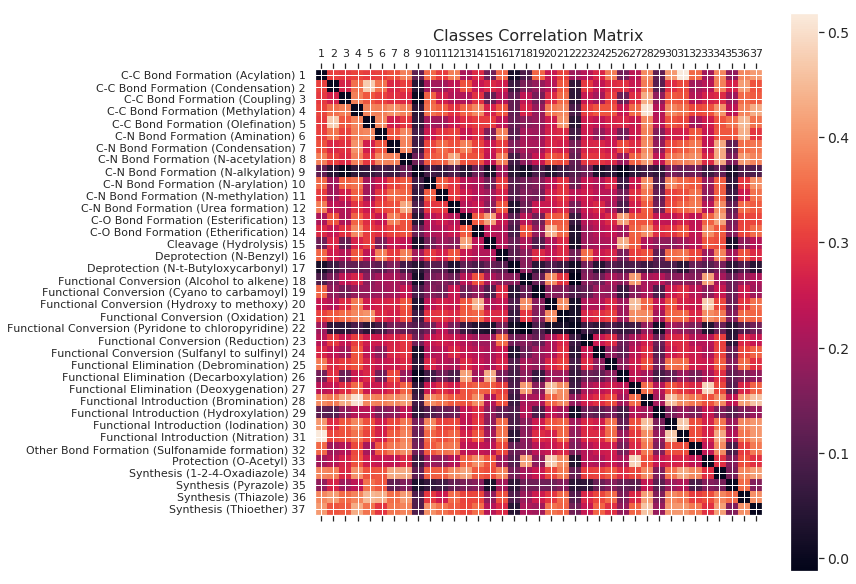

In [ ]:
# y (fullset) y_train and y is similar, y_test
corr = y.corr().replace(1, 0)
class_code = pd.DataFrame({'no':list(range(1,38)),'classes':y.columns})    
sns.set(rc={'figure.figsize':(24,10)})
#f = plt.figure(figsize=(19, 15))
plt.matshow(corr)
plt.xticks(range(corr.shape[1]), class_code['no'])
plt.yticks(range(corr.shape[1]), class_code['classes']+' '+class_code['no'].map(str))
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Classes Correlation Matrix', fontsize=16);

In [ ]:
# highest values in corr matrix
corr.max().sort_values(ascending=False)[:14]

C-C Bond Formation (Acylation)                  0.058418
Functional Introduction (Nitration)             0.058418
Functional Introduction (Iodination)            0.049515
Functional Introduction (Bromination)           0.049515
Protection (O-Acetyl)                           0.046678
Functional Conversion (Hydroxy to methoxy)      0.046678
C-C Bond Formation (Olefination)                0.046207
C-C Bond Formation (Condensation)               0.046207
C-O Bond Formation (Etherification)             0.038934
C-N Bond Formation (Urea formation)             0.030560
Other Bond Formation (Sulfonamide formation)    0.030560
C-N Bond Formation (N-acetylation)              0.028540
Functional Conversion (Oxidation)               0.028427
C-C Bond Formation (Methylation)                0.019525
dtype: float64

In [ ]:
# lowest values in corr matrix for each class
pd.DataFrame(corr.min().sort_values()).T

,C-C Bond Formation (Coupling),C-N Bond Formation (Condensation),C-N Bond Formation (N-methylation),C-O Bond Formation (Etherification),C-N Bond Formation (N-arylation),Deprotection (N-t-Butyloxycarbonyl),Functional Introduction (Bromination),Other Bond Formation (Sulfonamide formation),C-N Bond Formation (Urea formation),C-C Bond Formation (Methylation),Synthesis (Thioether),Functional Conversion (Alcohol to alkene),C-O Bond Formation (Esterification),Functional Conversion (Sulfanyl to sulfinyl),C-N Bond Formation (Amination),Functional Elimination (Decarboxylation),Synthesis (Thiazole),C-N Bond Formation (N-alkylation),C-N Bond Formation (N-acetylation),Functional Conversion (Hydroxy to methoxy),Functional Conversion (Reduction),Functional Elimination (Deoxygenation),Deprotection (N-Benzyl),Functional Conversion (Oxidation),Functional Introduction (Iodination),Synthesis (1-2-4-Oxadiazole),Functional Elimination (Debromination),C-C Bond Formation (Olefination),Protection (O-Acetyl),Functional Conversion (Cyano to carbamoyl),Functional Conversion (Pyridone to chloropyridine),C-C Bond Formation (Condensation),Functional Introduction (Hydroxylation),Synthesis (Pyrazole),Functional Introduction (Nitration),C-C Bond Formation (Acylation),Cleavage (Hydrolysis)
0,-0.109513,-0.109513,-0.086987,-0.071305,-0.071305,-0.070029,-0.068504,-0.060801,-0.058726,-0.058088,-0.058044,-0.056484,-0.055059,-0.052722,-0.051612,-0.048506,-0.046141,-0.043065,-0.041595,-0.041566,-0.040988,-0.040838,-0.040155,-0.039424,-0.039121,-0.035331,-0.033271,-0.032698,-0.031958,-0.031888,-0.031757,-0.030441,-0.029829,-0.028391,-0.027197,-0.027107,-0.026413


In [ ]:
np.sort(corr.values, axis=None)[:10]

array([-0.11373466, -0.11373466, -0.09068212, -0.09068212, -0.07177057,
       -0.07177057, -0.06878935, -0.06878935, -0.06715414, -0.06715414])

## Label frequency (per entry) distribution


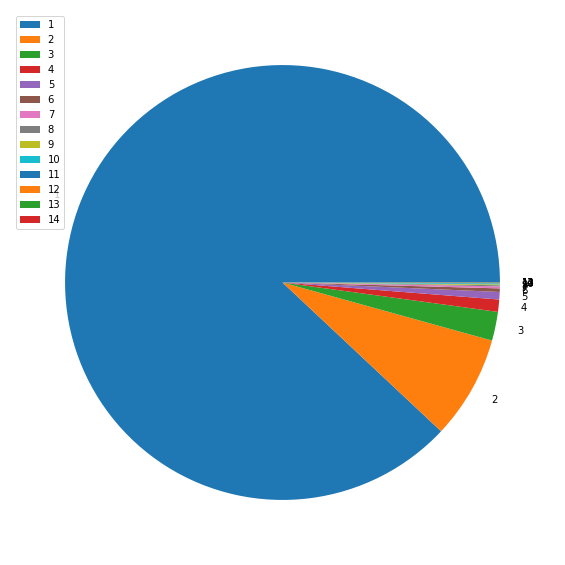

In [ ]:
# class_freq.plot.pie(y='Label Count Frequency',figsize=(10,10),legend=None)
plt.figure(figsize=(12, 10))
plt.pie(class_freq['Label Count Frequency'], labels=class_freq['Label Count'],autopct='%.2f')
plt.legend(loc='upper left')

In [ ]:
from collections import Counter
class_freq = pd.DataFrame(Counter(y.T.sum()).items(), columns=['Label Count','Label Count Frequency'])
class_freq.index=class_freq['Label Count']
class_freq = class_freq.sort_index(axis=0)
class_freq.head()

,Label Count,Label Count Frequency
Label Count,,
1,1,22047
2,2,1926
3,3,537
4,4,228
5,5,139


In [ ]:
class_freq = pd.DataFrame(Counter(y.T.sum()).items(), columns=['Label Count','freq']).T
class_freq.sort_index(axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Label Count,8,1,3,2,6,4,5,10,7,9,14,13,11,12
freq,21,22047,537,1926,66,228,139,17,37,16,3,5,5,4


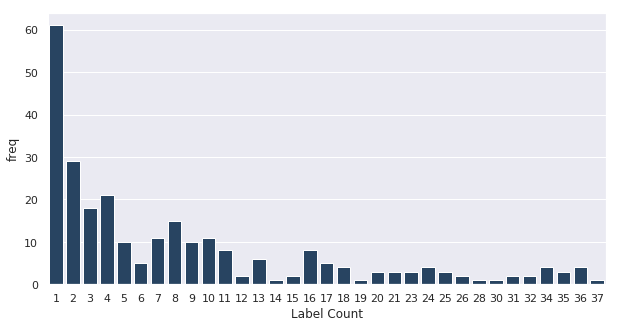

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x="Label Count", y="freq", data=class_freq,color='#1e446b')

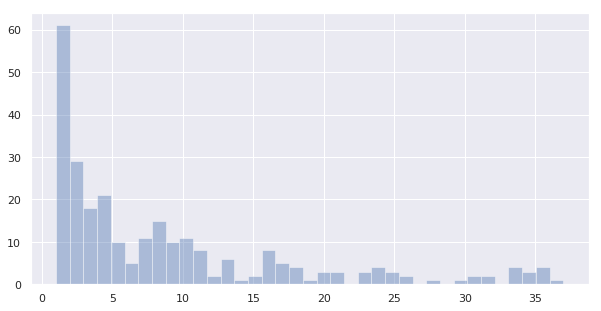

In [ ]:
sns.distplot(y.T.sum(), kde=False,bins=37)
# plt.xlim(0,)


## Classes Relations

In [ ]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(np.array(y))
print("{} labels, {} edges".format(len(y.columns), len(edge_map)))
print(edge_map) #527 edge + 37edge = 564 (classPair columns)

37 labels, 666 edges
{(0, 2): 74.0, (0, 3): 66.0, (2, 3): 230.0, (0, 4): 35.0, (2, 4): 102.0, (3, 4): 97.0, (0, 5): 56.0, (2, 5): 172.0, (3, 5): 162.0, (4, 5): 84.0, (0, 6): 71.0, (2, 6): 215.0, (3, 6): 211.0, (4, 6): 79.0, (5, 6): 158.0, (0, 7): 51.0, (2, 7): 118.0, (3, 7): 121.0, (4, 7): 53.0, (5, 7): 104.0, (6, 7): 127.0, (0, 9): 72.0, (2, 9): 220.0, (3, 9): 190.0, (4, 9): 65.0, (5, 9): 131.0, (6, 9): 186.0, (7, 9): 112.0, (0, 10): 73.0, (2, 10): 231.0, (3, 10): 214.0, (4, 10): 75.0, (5, 10): 164.0, (6, 10): 230.0, (7, 10): 130.0, (9, 10): 213.0, (0, 11): 60.0, (2, 11): 132.0, (3, 11): 127.0, (4, 11): 57.0, (5, 11): 110.0, (6, 11): 142.0, (7, 11): 103.0, (9, 11): 128.0, (10, 11): 149.0, (0, 12): 34.0, (2, 12): 108.0, (3, 12): 118.0, (4, 12): 53.0, (5, 12): 81.0, (6, 12): 131.0, (7, 12): 73.0, (9, 12): 93.0, (10, 12): 114.0, (11, 12): 70.0, (0, 13): 64.0, (2, 13): 214.0, (3, 13): 207.0, (4, 13): 86.0, (5, 13): 146.0, (6, 13): 195.0, (7, 13): 115.0, (9, 13): 157.0, (10, 13): 189.0, (1

In [ ]:
# calculate combination number
# 37 labels -> 666 combinations

# sum([i for i in range(37)])

666

In [ ]:
pd.DataFrame(edge_map.items()).sort_values(by=[1]).min()

0    (0, 1)
1         5
dtype: object

In [ ]:
# Comparing to the skmulearn's labels pari
classPair[['full']].T

,"(0, 0)","(0, 1)","(0, 10)","(0, 11)","(0, 12)","(0, 13)","(0, 14)","(0, 15)","(0, 16)","(0, 17)","(0, 18)","(0, 19)","(0, 2)","(0, 20)","(0, 21)","(0, 22)","(0, 23)","(0, 24)","(0, 25)","(0, 26)","(0, 27)","(0, 28)","(0, 29)","(0, 3)","(0, 30)","(0, 31)","(0, 32)","(0, 33)","(0, 34)","(0, 35)","(0, 36)","(0, 4)","(0, 5)","(0, 6)","(0, 7)","(0, 8)","(0, 9)","(1, 1)","(1, 10)","(1, 11)",...,"(8, 27)","(8, 28)","(8, 29)","(8, 30)","(8, 31)","(8, 32)","(8, 33)","(8, 34)","(8, 35)","(8, 36)","(8, 8)","(8, 9)","(9, 10)","(9, 11)","(9, 12)","(9, 13)","(9, 14)","(9, 15)","(9, 16)","(9, 17)","(9, 18)","(9, 19)","(9, 20)","(9, 21)","(9, 22)","(9, 23)","(9, 24)","(9, 25)","(9, 26)","(9, 27)","(9, 28)","(9, 29)","(9, 30)","(9, 31)","(9, 32)","(9, 33)","(9, 34)","(9, 35)","(9, 36)","(9, 9)"
full,83,40,73,60,34,64,15,34,7,19,42,39,74,41,21,24,48,51,22,33,75,16,52,66,59,61,27,44,16,50,70,35,56,71,51,23,72,153,88,63,...,57,19,42,35,59,26,32,10,34,51,182,60,213,128,93,157,40,70,41,69,64,98,96,44,61,111,100,48,88,190,42,116,99,149,68,93,23,99,168,373


In [ ]:
from skmultilearn.cluster import NetworkXLabelGraphClusterer

clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain') #label_propagation or louvarin
partition = clusterer.fit_predict(np.array(X),np.array(y))
partition

array([list([0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 15, 18, 21, 22, 23, 24, 27, 29, 30, 31, 33, 35, 36]),
       list([1, 4, 12, 13, 14, 16, 17, 19, 20, 25, 26, 28, 32, 34])],
      dtype=object)

In [ ]:
# clusterer.graph_.get_edge_data(0,3)
weights = [edge_map[i] for i in clusterer.graph_.edges]

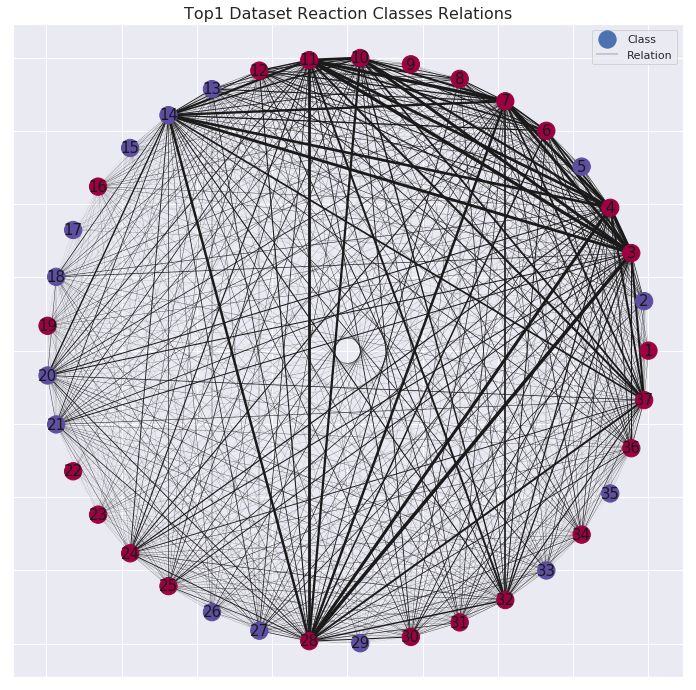

In [ ]:
membership_vector = {member:partition_id for partition_id, members in enumerate(partition) for member in members}
import networkx as nx
import matplotlib.pyplot as plt
 
sns.set(rc={'figure.figsize':(12,12)})
nx.draw_networkx(
    clusterer.graph_,
    pos=nx.circular_layout(clusterer.graph_),
    labels=pd.Series(range(1,38)),
#     labels=dict(enumerate([n for l in partition for n in l])),
    with_labels = True,
# manully get weight : edge_map[i] for i in clusterer.graph_.edge]
# clusterer.weights_['weight']
    width = [w*w/y.shape[0]/10 for w in weights],
    node_color = [membership_vector[i] for i in range(y.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=300,
    font_size=15
)
## w*w/y.shape[0]/10
## FCFP2,4 W*W*10/y.shape[0]
## Top5,10,15,20,25,50 w*w*10/y.shape[0]
plt.legend(['Class','Relation'],loc='best')
plt.title('{} Dataset Reaction Classes Relations'.format(FINGERPRINT), fontsize=16);

In [ ]:
y_flat = y.unstack().reset_index(name='value')
y_flat.rename(columns={'level_0': 'class', 'level_1': 'rowID'}, inplace=True)
y_items = pd.DataFrame(y_flat[y_flat['value']==1].groupby('rowID').apply(lambda x: list(x['class'])).reset_index(name='classes'))

In [ ]:
y_items.iloc[4,1]

['C-C Bond Formation (Methylation)',
 'C-C Bond Formation (Olefination)',
 'C-N Bond Formation (N-methylation)',
 'Functional Conversion (Hydroxy to methoxy)',
 'Functional Introduction (Iodination)']